## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Carga de datos

In [3]:
ind_2 = pd.read_csv('df_sueño_pasos_2.csv')
ind_2 = ind_2.drop(columns=['Unnamed: 0'])
ind_2.head()

,Hora Dormir,Minuto Dormir,Hora Despertar,Minuto Despertar,Tiempo Durmiendo (s),Ligero (s),Profundo (s),Despierto (s),Conciliación (s),Tiempo en Levantarse (s),Interrupciones,Pasos
0,2,3,6,54,16080,10020,6060,1380,1380,0,0,6337
1,2,30,7,29,16620,13380,3240,1320,0,0,1,12161
2,1,7,10,1,31620,23520,8100,420,360,60,0,14541
3,0,57,9,35,29100,23460,5640,1980,360,0,2,7817
4,1,46,6,41,17160,11040,6120,540,360,0,1,7798


In [4]:
ind_2.shape

(86, 12)

In [5]:
seed = 2024

## Eliminación de outliers

In [6]:
Q1 = ind_2[['Tiempo Durmiendo (s)', 'Pasos']].quantile(0.25)
Q3 = ind_2[['Tiempo Durmiendo (s)', 'Pasos']].quantile(0.75)
IQR = Q3 - Q1

In [7]:
lower_bound = Q1 #- 1 * IQR
upper_bound = Q3 #+ 1 * IQR

In [8]:
print(lower_bound['Pasos'])
print(upper_bound['Pasos'])
print(lower_bound['Tiempo Durmiendo (s)'])
print(upper_bound['Tiempo Durmiendo (s)'])

7961.75
13691.25
11820.0
22155.0


In [9]:
# Filtrar los datos eliminando registros donde ambas variables sean mayores al upper bound
data_filtered = ind_2[~((ind_2['Tiempo Durmiendo (s)'] > upper_bound['Tiempo Durmiendo (s)']) & (ind_2['Pasos'] > upper_bound['Pasos']))]

# Filtrar los datos eliminando registros donde ambas variables sean menores al lower bound
data_filtered = data_filtered[~((ind_2['Tiempo Durmiendo (s)'] < lower_bound['Tiempo Durmiendo (s)']) & (ind_2['Pasos'] < lower_bound['Pasos']))]

In [10]:
data_filtered.shape

(73, 12)

In [11]:
umbral_dormir_mucho = upper_bound['Tiempo Durmiendo (s)']
umbral_dormir_poco = lower_bound['Tiempo Durmiendo (s)']
umbral_caminar_poco = lower_bound['Pasos']
umbral_caminar_mucho = upper_bound['Pasos']

# Clasificar los datos en grupos
data_filtered['Grupo'] = 'Eutimia'
data_filtered.loc[(data_filtered['Tiempo Durmiendo (s)'] > umbral_dormir_mucho) & (data_filtered['Pasos'] < umbral_caminar_poco), 'Grupo'] = 'Depresión'
data_filtered.loc[(data_filtered['Tiempo Durmiendo (s)'] < umbral_dormir_poco) & (data_filtered['Pasos'] > umbral_caminar_mucho), 'Grupo'] = 'Manía'

In [12]:
data_filtered['Grupo'].value_counts()

Grupo
Eutimia      63
Depresión     5
Manía         5
Name: count, dtype: int64

In [13]:
mapeo_grupos = {'Eutimia': 1, 'Depresión': 2, 'Manía': 3}
data_filtered['Grupo_mapped'] = data_filtered['Grupo'].map(mapeo_grupos)

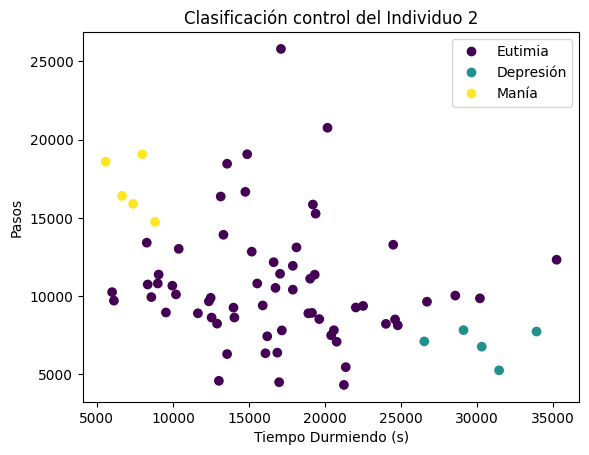

In [14]:
scatter = plt.scatter(data_filtered['Tiempo Durmiendo (s)'], data_filtered['Pasos'], c=data_filtered['Grupo_mapped'], cmap='viridis')

handles, labels = scatter.legend_elements()
legend_labels = [key for key, value in mapeo_grupos.items()]
plt.legend(handles, legend_labels)

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
plt.title('Clasificación control del Individuo 2')
plt.show()

## Propuesta modelo clasificación

In [15]:
def algoritmo_clasificacion(df):
    # Inicializar contadores para cada combinación de Grupo y Cluster
    contador = {
        'Eutimia': [0, 0, 0],
        'Depresión': [0, 0, 0],
        'Manía': [0, 0, 0]
    }

    # Contar las coincidencias
    for i in range(len(df)):
        grupo = df['Grupo'].iloc[i]
        cluster = df['Cluster'].iloc[i]
        if grupo in contador and cluster in [0, 1, 2]:
            contador[grupo][cluster] += 1

    # Determinar el grupo principal para Eutimia
    max_eutimia_value = max(contador['Eutimia'])
    grupo_eutimia = contador['Eutimia'].index(max_eutimia_value)

    # Determinar los grupos restantes (excluyendo el grupo principal de Eutimia)
    grupos_restantes = [i for i in [0, 1, 2] if i != grupo_eutimia]

    # Evaluar combinaciones para Depresión y Manía
    dep_mania_combinations = [
        (grupos_restantes[0], grupos_restantes[1]),
        (grupos_restantes[1], grupos_restantes[0])
    ]

    max_total = 0
    mejor_combination = None

    for comb in dep_mania_combinations:
        total = max_eutimia_value + contador['Depresión'][comb[0]] + contador['Manía'][comb[1]]
        if total > max_total:
            max_total = total
            mejor_combination = comb

    # Resultado final
    resultado = {
        "Eutimia": grupo_eutimia,
        "Depresión": mejor_combination[0],
        "Manía": mejor_combination[1],
        "Total Correct Matches": max_total
    }

    return resultado

## Modelo KMeans

In [16]:
data_filtered = data_filtered.dropna()

In [17]:
data_filtered.shape

(73, 14)

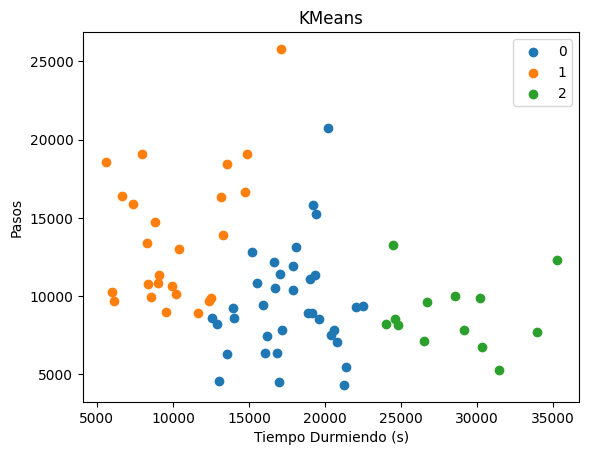

In [18]:
kmeans = KMeans(n_clusters=3, random_state=seed)
kmeans.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada muestra
cluster_labels = kmeans.labels_
data_filtered['Cluster'] = kmeans.labels_

# Iterar sobre cada cluster y graficar los puntos correspondientes
for cluster in set(cluster_labels):
    x_cluster = data_filtered.loc[cluster_labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[cluster_labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}', cmap='viridis')

# Agregar leyenda
plt.legend()

# Personalizar el gráfico
plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('KMeans')
# Mostrar el gráfico
plt.show()

In [19]:
# Clasificación de los clústeres
agg_km = pd.DataFrame(cluster_labels)
agg_km.value_counts()

0    35
1    25
2    13
Name: count, dtype: int64

In [20]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 2, 'Manía': 1, 'Total Correct Matches': 45}

## Agglomerative Clustering

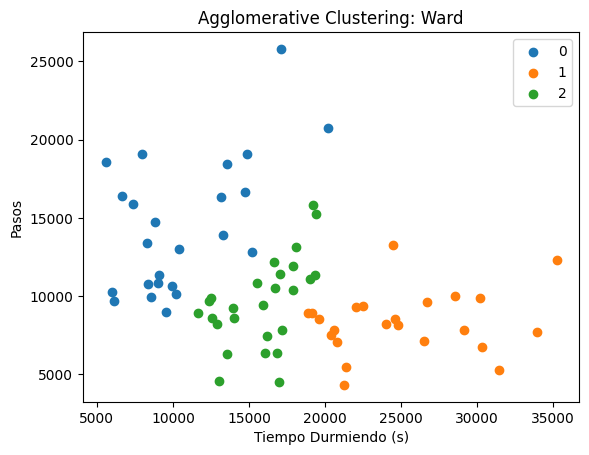

In [21]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Ward')
plt.legend()
plt.show()

In [22]:
# Clasificación de los clústeres
agg_ward = pd.DataFrame(labels)
agg_ward.value_counts()

2    26
0    24
1    23
Name: count, dtype: int64

In [23]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 2, 'Depresión': 1, 'Manía': 0, 'Total Correct Matches': 36}

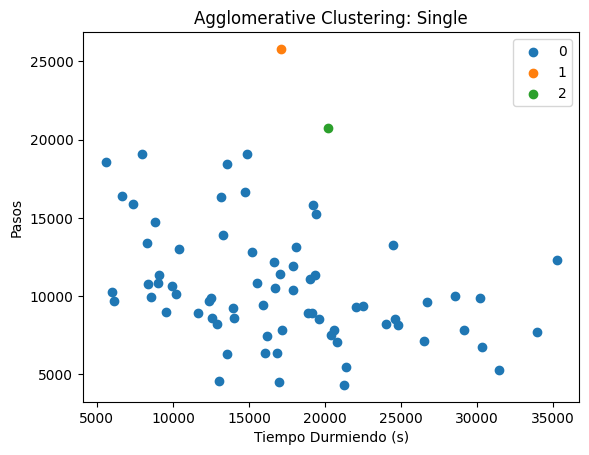

In [24]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='single')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Single')
plt.legend()
plt.show()

In [25]:
# Clasificación de los clústeres
agg_single = pd.DataFrame(labels)
agg_single.value_counts()

0    71
1     1
2     1
Name: count, dtype: int64

In [26]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 1, 'Manía': 2, 'Total Correct Matches': 61}

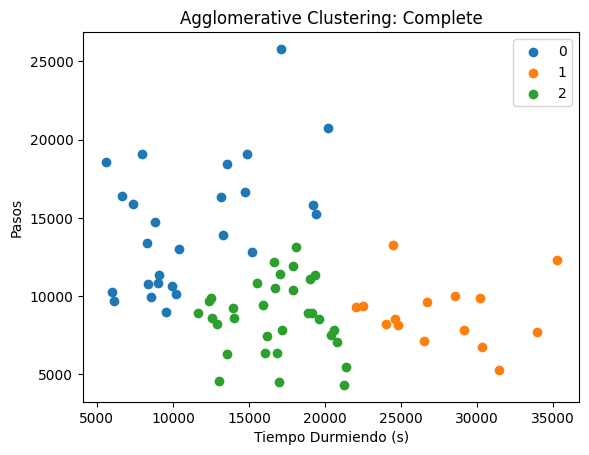

In [27]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Complete')
plt.legend()
plt.show()

In [28]:
# Clasificación de los clústeres
agg_complete = pd.DataFrame(labels)
agg_complete.value_counts()

2    32
0    26
1    15
Name: count, dtype: int64

In [29]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 2, 'Depresión': 1, 'Manía': 0, 'Total Correct Matches': 42}

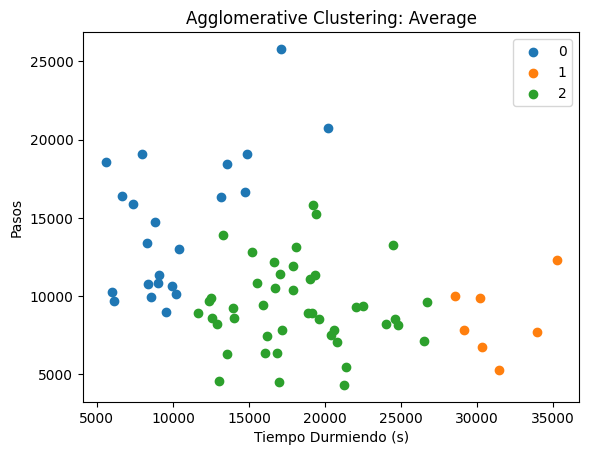

In [30]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='average')

# Ajustar el modelo a los datos
clustering.fit(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']])

# Obtener las etiquetas de los clusters asignadas a cada punto
labels = clustering.labels_
data_filtered['Cluster'] = clustering.labels_

for cluster in set(labels):
    #data_cluster = data_filtered_ward[data_filtered_ward['Ward'] == cluster]
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
#plt.xticks(ticks=[15000, 20000, 25000, 30000, 35000])
plt.title('Agglomerative Clustering: Average')
plt.legend()
plt.show()

In [31]:
# Clasificación de los clústeres
agg_average = pd.DataFrame(labels)
agg_average.value_counts()

2    44
0    22
1     7
Name: count, dtype: int64

In [32]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 2, 'Depresión': 1, 'Manía': 0, 'Total Correct Matches': 52}

## BDSCAN

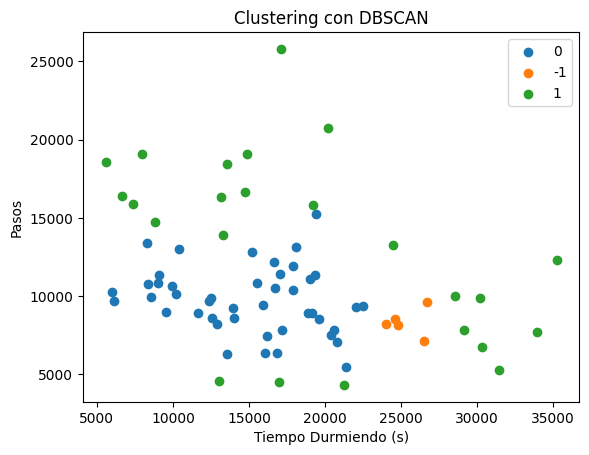

In [33]:
dbscan = DBSCAN(eps=2500, min_samples=6)
labels = dbscan.fit_predict(data_filtered[['Tiempo Durmiendo (s)', 'Pasos', 'Interrupciones']])

# Añadir las etiquetas al DataFrame original
data_filtered['Cluster'] = labels

# Crear la leyenda
for cluster in set(labels):
    x_cluster = data_filtered.loc[labels == cluster, 'Tiempo Durmiendo (s)']
    y_cluster = data_filtered.loc[labels == cluster, 'Pasos']
    plt.scatter(x_cluster, y_cluster, label=f'{cluster}')

# Visualización (solo si tienes dos características)
#plt.scatter(data_filtered['Tiempo Durmiendo (s)'], data_filtered['Pasos'], c=labels, cmap='viridis')
plt.title('Clustering con DBSCAN')
plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
plt.legend([0, -1, 1])
plt.show()

In [34]:
# Clasificación de los clústeres
agg_dbscan = pd.DataFrame(labels)
agg_dbscan.value_counts()

 0    44
-1    24
 1     5
Name: count, dtype: int64

In [35]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 1, 'Manía': 2, 'Total Correct Matches': 45}

## GMM

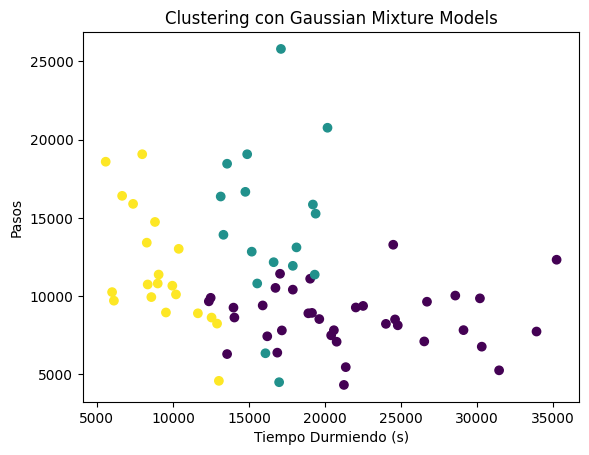

In [36]:
# Definir el número de clústeres
num_clusters = 3

# Inicializar y ajustar el modelo GMM
gmm = GaussianMixture(n_components=num_clusters, random_state=seed)
labels = gmm.fit_predict(data_filtered[['Tiempo Durmiendo (s)', 'Interrupciones', 'Pasos']])

# Añadir las etiquetas al DataFrame original
data_filtered['Cluster'] = labels

# Visualización
plt.scatter(data_filtered['Tiempo Durmiendo (s)'], data_filtered['Pasos'], c=labels, cmap='viridis')
plt.title('Clustering con Gaussian Mixture Models')
plt.xlabel('Tiempo Durmiendo (s)')
plt.ylabel('Pasos')
plt.show()

In [37]:
# Clasificación de los clústeres
agg_gmm = pd.DataFrame(labels)
agg_gmm.value_counts()

0    36
2    20
1    17
Name: count, dtype: int64

In [38]:
algoritmo_clasificacion(data_filtered)

{'Eutimia': 0, 'Depresión': 1, 'Manía': 2, 'Total Correct Matches': 36}